In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.append('../')

from implementations import *

%load_ext autoreload
%autoreload 2

# **Load and clean the training data**

We load the training data.

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


We then clean the data by :
- preprocessing of all the features of the data
- removing the nan values by the median of the rest of the feature for continuous values
- removing the nan values by the -1 for categorical features


In [3]:
xt_feat = x_train
xt_feat = preprocessing(xt_feat)
xt_feat = gen_clean(xt_feat, [], np.arange(321))
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 321 features !


In [4]:
xt_z = xt_feat.copy()
for i in np.array([0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 19, 20, 21, 22, 23, 88, 91, 101, 105]):
    xt_z[:, i] = 0

# **PCA algorithm**

In [5]:
pca_indices, idx = pca(xt_z)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 117 first most influent features given by pca_indices


In [6]:
x_train_pca = xt_z[:, pca_indices]
x_train_pca = x_train_pca[:, :idx]

print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 117 features


# Ridge regression

We find the Ridge regression solutions using the normal equations.

First, we separate our data in a training set (80%) and testing set (20%).

In [20]:
tx_tr, tx_te, y_tr, y_te = cross(x_train_pca, y_train, 0.8)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (262508, 117) ; tx_te shape : (65627, 117)
       y_tr : (262508,)     ;        y_te : (65627,)


Now we build our models for linear regression

In [21]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 118 features !


## Linear regression using ridge regression

Here we train our model using ridge regression with normal equations

In [9]:
start_time = datetime.datetime.now()

degrees = np.arange(2, 4)
lambdas = np.logspace(-4, 0, 30)

best_degree, best_lambda, best_rmse = best_degree_selection(y, tx, degrees, 4, lambdas)

end_time = datetime.datetime.now()

print(
    "The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f."
    % (best_rmse, best_degree, best_lambda)
)

print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Degree 2 done !
Degree 3 done !
The best rmse of 0.517 is obtained for a degree of 2 and a lambda of 0.00092.
Execution time 389.4705 seconds


In [10]:
best_degree = 2
best_lambda = 0.01610
lambdazz = 0.00092
tx_tr = build_poly(tx, best_degree)
tx_te_poly = build_poly(tx_test, best_degree)

w, loss = ridge_regression(y, tx_tr, best_lambda)

In [4]:
print(tx_tr.shape)
print(tx_te_poly.shape)

# Computation of metrics

We first compute some metrics on the training data (60% of the total data)

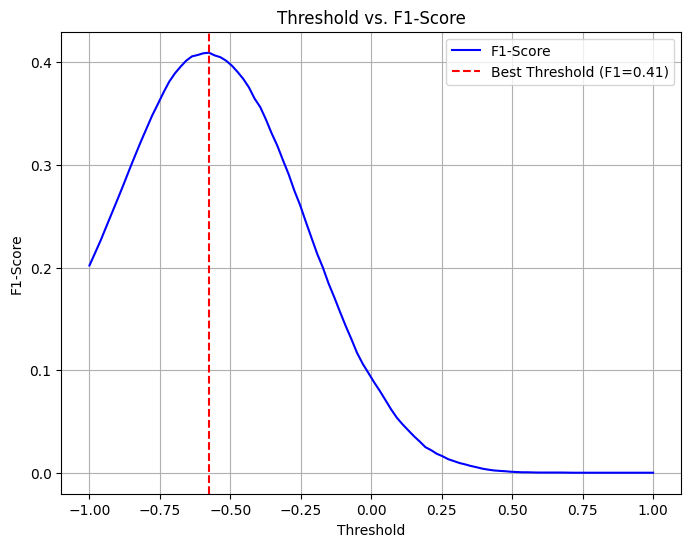

In [12]:
best_thresh = best_threshold(y, tx_tr, w)

In [13]:
pred_data = np.dot(tx_tr, w)

pred_data[pred_data > best_thresh] = 1
pred_data[pred_data < best_thresh] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 86.6826915751139%
Precision: 33.57904946653734%
Recall : 52.436385667301366%
F1-score : 40.940651766256146%


In [14]:
pred_test = np.dot(tx_te_poly, w)

pred_test[pred_test > best_thresh] = 1
pred_test[pred_test < best_thresh] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 86.65488289880689%
Precision: 34.08915795266923%
Recall : 52.786773478779615%
F1-score : 41.425896201177096%


# **Prediction on test data**

In [15]:
start_time = datetime.datetime.now()

tx_test = x_test
tx_test = preprocessing(x_test)
tx_test = gen_clean(tx_test, [], np.arange(321))

tx_test = tx_test[:, pca_indices]
tx_test = tx_test[:, :idx]
tx_test = np.c_[np.ones(tx_test.shape[0]), tx_test]

tx_test = build_poly(tx_test, best_degree)

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")
print(f"The data has {tx_test.shape[0]} samples and {tx_test.shape[1]} features !")

Execution time 5.316855 seconds
The data has 109379 samples and 237 features !


In [16]:
pred_te = np.dot(tx_test, w)

pred_te[pred_te > best_thresh] = 1
pred_te[pred_te < best_thresh] = -1

indices_one = np.where(pred_te == 1)

In [17]:
create_csv_submission(test_ids, pred_te, "data/ridge_reg.csv")